# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
from bs4 import BeautifulSoup

In [3]:
from collections import Counter
from typing import List, Dict

In [4]:
from PIL import Image
import cv2

In [5]:
import os
from glob import glob

In [6]:
import pytesseract
import easyocr

In [7]:
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics YOLOv8.1.10 🚀 Python-3.10.5 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660, 6144MiB)
Setup complete ✅ (12 CPUs, 15.9 GB RAM, 746.2/931.5 GB disk)


## Константы

In [8]:
seed = 42
train_dataset_path = "./Data/train"
test_dataset_path = "./Data/test"
pytesseract.pytesseract.tesseract_cmd = './Tesseract-OCR/tesseract.exe'
tesseract_configs = r'--oem 3 --psm 6 -l eng'

In [9]:
reader = easyocr.Reader(['en'])

In [9]:
# Список всех файлов jpeg в обучающей выборке и тестовой
train_jpeg_files = glob(train_dataset_path + '/*.jpeg')
test_jpeg_files = glob(test_dataset_path + '/*.jpeg')

# Разведочный анализ данных

In [11]:
# Проверим, сколько уникальных форматов файлов хранится в данных
set(map(lambda x: x.split('.')[-1], os.listdir(train_dataset_path)))

{'jpeg', 'png', 'txt', 'xml'}

In [12]:
# Отсортируем данные обучающей выборки по названиям файлов
train_folder = [x for x in sorted(os.listdir(train_dataset_path)) if not x.endswith('.txt')]

In [13]:
# Словарь, где ключ - путь до картинки, значение - путь до xml файла выбранной картинки
data_dict = {}
for i in range(0, len(train_folder), 2):
    data_dict[train_folder[i]] = train_folder[i+1]

In [14]:
list(data_dict.items())[:3]

[('ckictsenl0000246a2itn28ts.jpeg', 'ckictsenl0000246a2itn28ts.xml'),
 ('ckictw05s0001246aeel6cew4.jpeg', 'ckictw05s0001246aeel6cew4.xml'),
 ('ckictycsy0002246ajt63dkm5.jpeg', 'ckictycsy0002246ajt63dkm5.xml')]

## Визуализация примеров данных

In [15]:
def visualize_data(data: Dict[str, str], N: int):
    # Путь до данных
    path = train_dataset_path + '/'

    # Отдельно запишем ключи словаря
    keys = list(data.keys())
    
    plt.figure(figsize=(20, N / 2))
    
    for i in range(N):
        plt.subplot(ceil(N / 5), 5, i+1)
        plt.axis('Off')
        # JPEG
        key = np.random.choice(keys)
        # XML
        with open(path + data[key], 'r') as file:
            xml_data = BeautifulSoup(file, 'xml')
            # Цифры со знака на картинке
            label = ''.join([x.text for x in xml_data.find_all('name')])
        
        image = plt.imread(path + key)
        plt.imshow(image)
        plt.title(f"Номер знака: {label}", pad=12)
    
    plt.show()

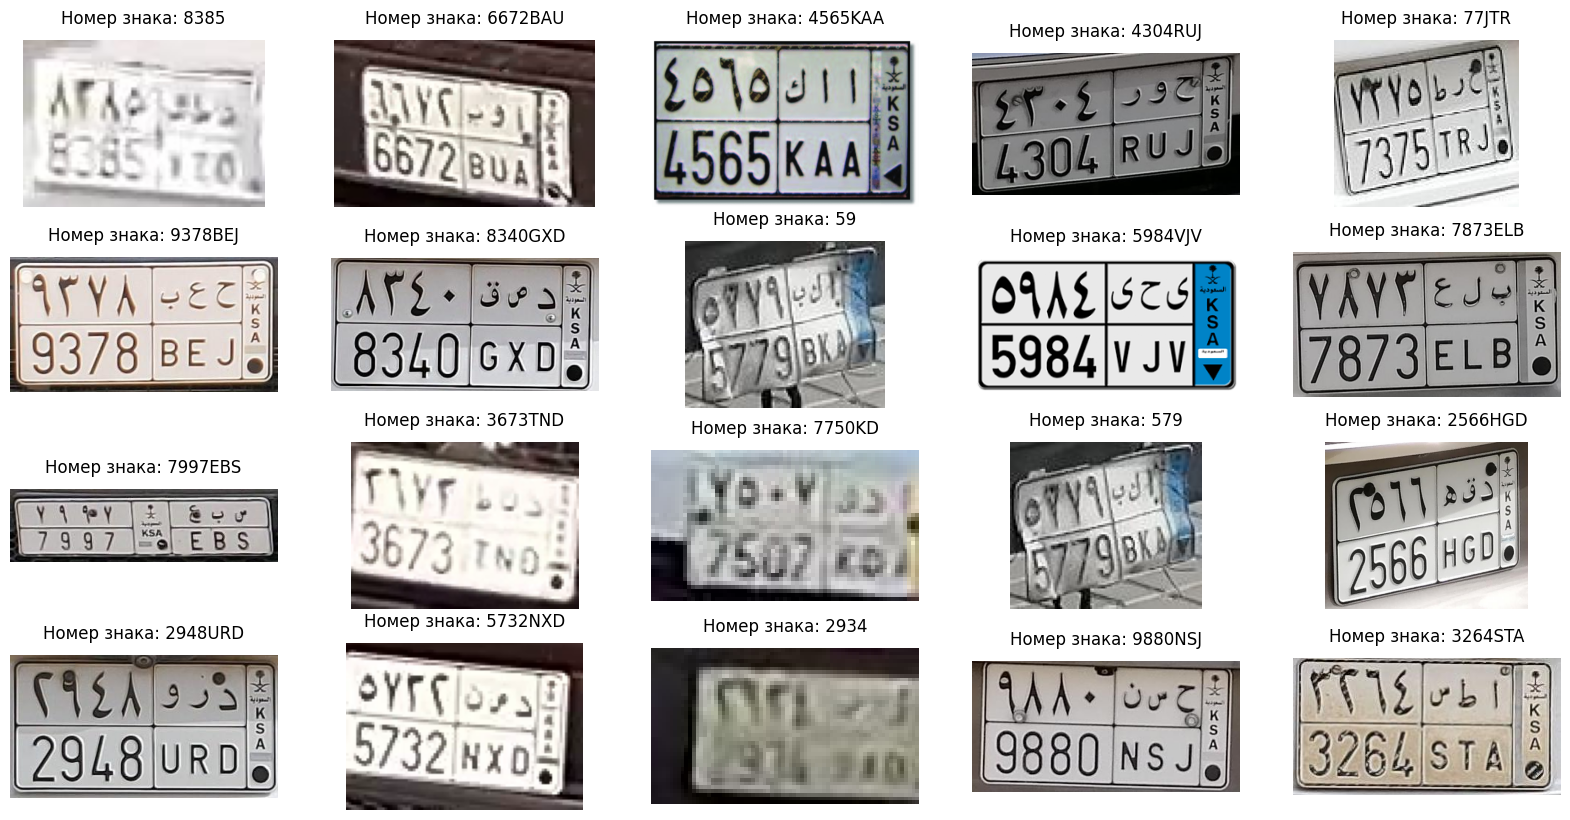

In [16]:
visualize_data(data=data_dict, N=20)

## Визуализация распределения классов в обучающей выборке

In [17]:
# Записываем в список все xml файлы для определения распределения классов из обучающей выборки
train_xml_files = glob(train_dataset_path + '/*.xml')

In [18]:
# Кол-во различных классов (символов)
counter = Counter()

for i in range(len(train_xml_files)):
    with open(train_xml_files[i], 'r') as f:
        data = f.read()

    counter.update([x.text for x in BeautifulSoup(data, "xml").find_all('name')])

In [19]:
# Топ 5 самых встречающихся классов в обучающей выборке
dict(counter.most_common(5))

{'7': 260, '3': 257, '5': 242, '2': 233, 'J': 233}

In [20]:
# Итоговое распределение всех классов
dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))

{'7': 260,
 '3': 257,
 '5': 242,
 '2': 233,
 'J': 233,
 '0': 220,
 '4': 208,
 '9': 191,
 'D': 190,
 '8': 175,
 '6': 173,
 'B': 165,
 'A': 157,
 '1': 156,
 'N': 102,
 'X': 83,
 'L': 70,
 'Z': 69,
 'V': 66,
 'S': 64,
 'T': 58,
 'R': 47,
 'K': 46,
 'H': 46,
 'G': 45,
 'E': 37,
 'U': 35}

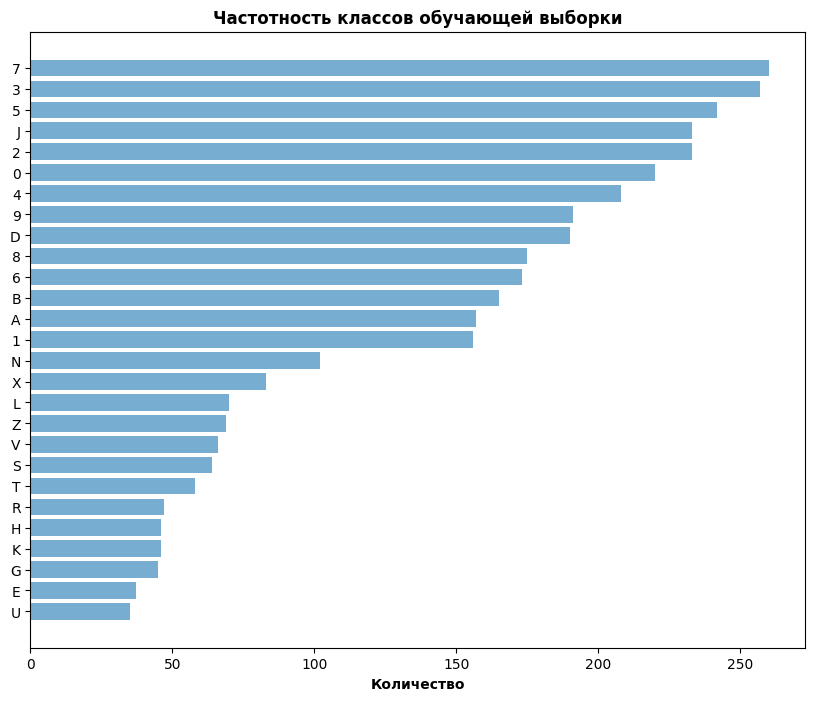

In [21]:
# График распределения классов обучающей выборки
ordered = dict(sorted(counter.items(), key=lambda item: item[1]))
keys = ordered.keys()
y_pos = np.arange(len(keys))
counts = [ordered[k] for k in keys]

plt.figure(figsize=(10, 8))
plt.barh(y_pos, counts, align='center', alpha=0.6)
plt.yticks(y_pos, keys)
plt.xlabel('Количество', weight='bold')
plt.title('Частотность классов обучающей выборки', weight='bold', fontsize=12)

plt.show()

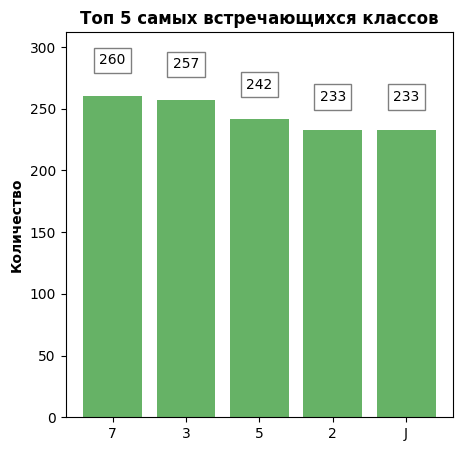

In [22]:
# Топ 5 самых популярных классов
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i] + 0.1 * y[i], y[i], ha = 'center',
                 bbox = dict(facecolor = 'white', alpha =.5, lw=1))


ordered = dict(sorted(counter.most_common(5), key=lambda item: item[1], reverse=True))
keys = ordered.keys()
y_pos = np.arange(len(keys))
counts = [ordered[k] for k in keys]

fig, ax = plt.subplots(figsize=(5, 5))

addlabels(y_pos, counts)
plt.bar(y_pos, counts, align='center', alpha=0.6, color = 'g')
plt.xticks(y_pos, keys)
ax.set_ylim([0,max(counts) + 0.2 * max(counts)])
plt.ylabel('Количество', weight='bold')
plt.title('Топ 5 самых встречающихся классов', weight='bold', fontsize=12)

plt.show()

## Базовая модель Tesseract от компании Google

**Tesseract-OCR** — это движок оптического распознавания символов (OCR) с открытым исходным кодом, является самой популярной и качественной OCR-библиотекой.

In [23]:
# Определение символов на знаках базовой моделью Tesseract
def draw_boxes_tesseract(img_file_name: str, tesseract_configs: str = tesseract_configs):
    # Считываем изображение
    img = cv2.imread(img_file_name)
    # Размеры изображения
    hImg, _, _ = img.shape
    boxes = pytesseract.image_to_boxes(img,
                                       config=tesseract_configs)
    for i in boxes.splitlines():
        i = i.split(' ')
        
        x, y, w, h = int(i[1]), int(i[2]), int(i[3]), int(i[4])
        
        # Нанесение границ вокруг предсказанного символа
        cv2.rectangle(img, (x, hImg - y), (w, hImg - h), (0, 0, 255), 1)

    return img

In [24]:
def visualize_base_tesseract_preds(data: List[str], N: int = 10, tesseract_configs: str = tesseract_configs):
    plt.figure(figsize=(30, N / 2))
    
    for i in range(N):
        # Построение рамок вокруг предсказанных символов
        img = draw_boxes_tesseract(data[i])

        plt.subplot(ceil(N / 5), 5, i+1)
        plt.axis('Off')
        
        # Предсказанные символы
        pred_label = ','.join(pytesseract.image_to_string(train_jpeg_files[i], config=tesseract_configs).replace('\n', '').split(' '))
        plt.imshow(img)
        plt.title(f"Предсказанное значение: {pred_label}", pad=12)
    
    plt.show()

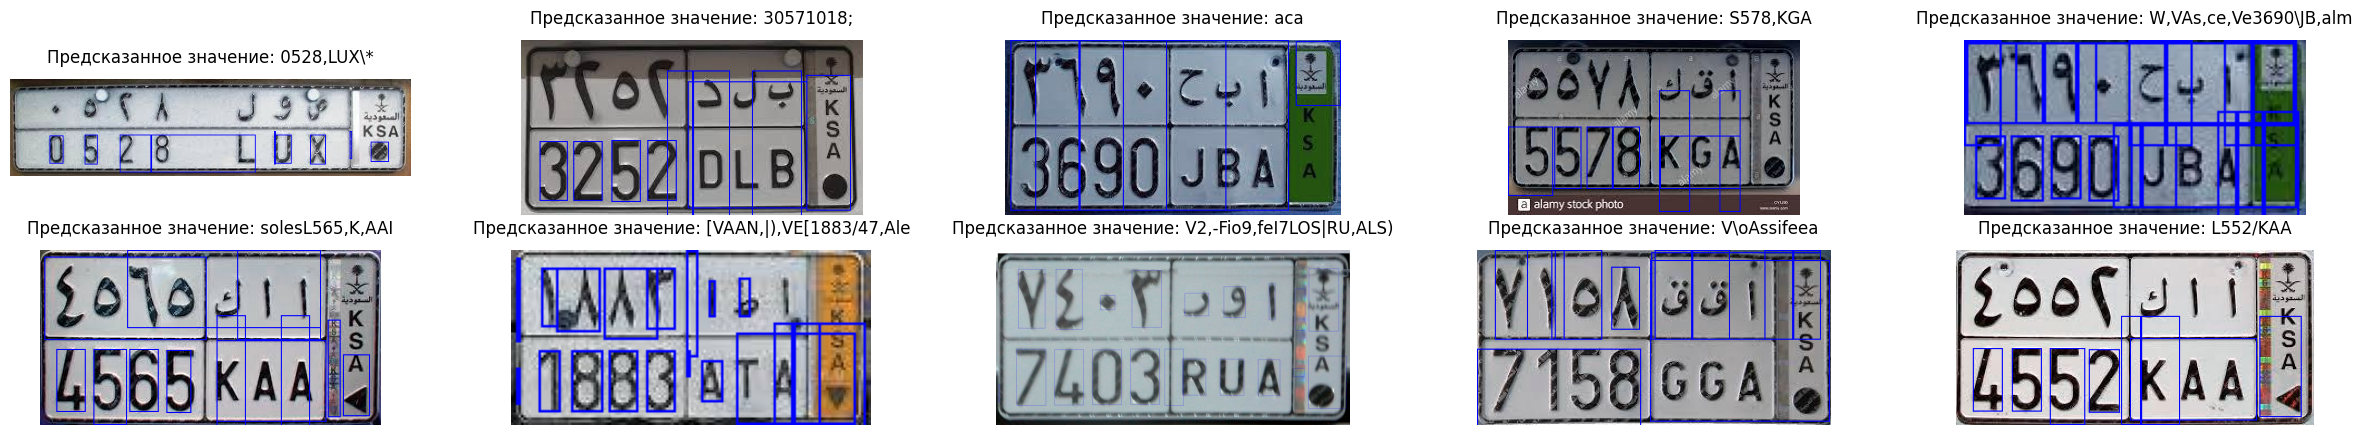

In [25]:
visualize_base_tesseract_preds(train_jpeg_files)

**Вывод** по модели Tesseract_base: Предсказания очень плохие, возможно из-за маленького размера изображений.

## Базовая модель EasyOCR

In [26]:
def draw_boxes_EasyOCR(img_file_name: str):
    # Считываем изображение
    img = cv2.imread(img_file_name)
    
    # Прогоняем изображение через модель EasyOCR
    pred = reader.readtext(img)
    
    
    for i in pred:
        # Если низкий 
        if i[-1] < 0.45:
            continue
        
        # Если выше то учитываем предсказание на картинке
        # Координаты границы (bbox)
        cords = i[0]
        # Название символа
        label = i[1]

        (x1, y1), (_, _), (x3, y3), (_, _) = cords
        try:
            cv2.rectangle(img, (x1, y1), (x3,y3), color=(255, 0, 0) , thickness=1)
            cv2.putText(img, label, (x1, y1), thickness=2,
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8,
                    color=(255, 0, 0))
        except:
            pass
        
    return img

In [27]:
def visualize_base_EasyOCR_preds(data: List[str], N: int = 10, reader=reader):
    
    plt.figure(figsize=(30, N / 2))
    
    for i in range(N):
        # Построение рамок вокруг предсказанных символов
        img = draw_boxes_EasyOCR(data[i])

        plt.subplot(ceil(N / 5), 5, i+1)
        plt.axis('Off')
        
        # Предсказанные символы
        plt.imshow(img)
    
    plt.show()

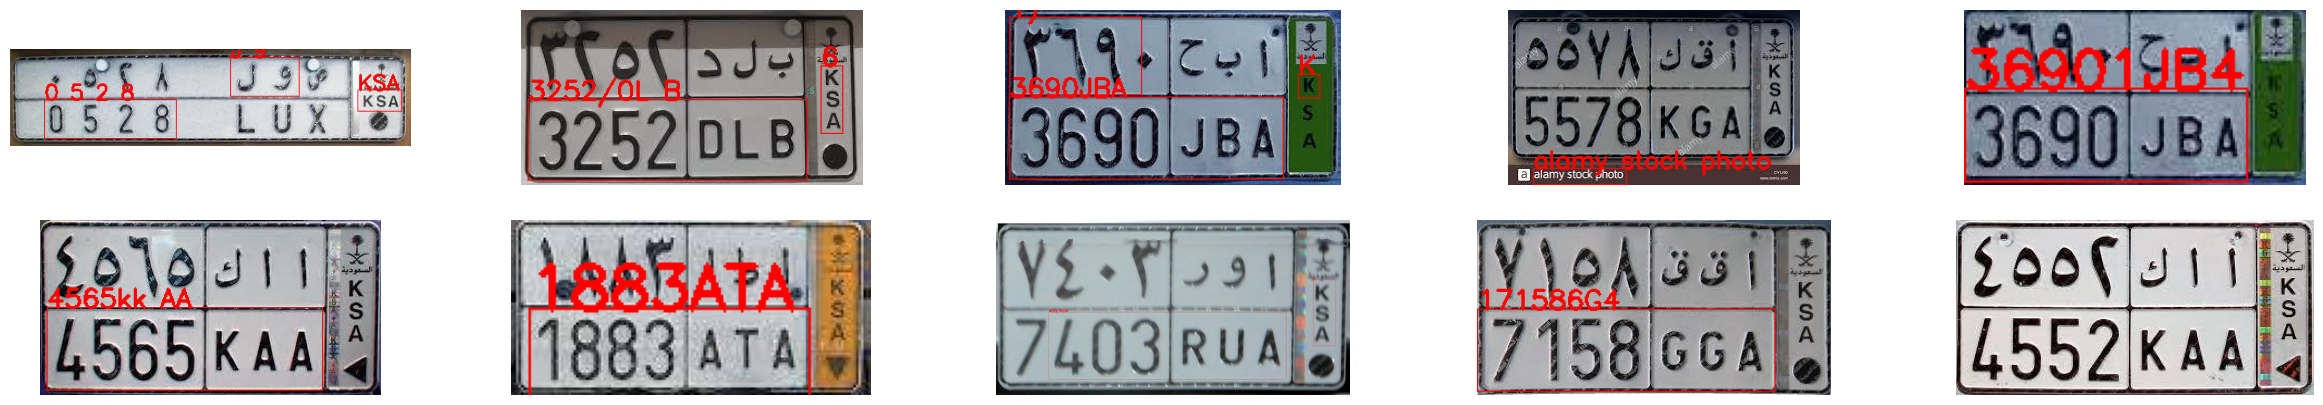

In [28]:
visualize_base_EasyOCR_preds(train_jpeg_files)

**Вывод** по базовой модели EasyOCR: Модель аккуратнее Tesseract. Но в остальном результаты также не очень точные.

# Обучение модели

Для детекции текста на изображениях возьму модель yolov8 и дообучу на подготовленных данных.

In [29]:
# Проверка путей до данных с обучающей выборкой и тестовой
print(train_dataset_path, test_dataset_path, sep='\n')

./Data/train
./Data/test


In [9]:
# Загрузка модели yolov8n
model = YOLO('weights/yolov8n.pt')

In [10]:
# Обучение модели на train_data
results = model.train(data='config.yaml', epochs=30, imgsz=640, seed=seed)

Ultralytics YOLOv8.1.10 🚀 Python-3.10.5 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660, 6144MiB)
engine\trainer: task=detect, mode=train, model=weights/yolov8n.pt, data=config.yaml, epochs=30, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True,

train: Scanning D:\Тестовые задания от it-компаний\ML CV Rutcod\Test-CV-Rutcod\Data\train... 563 images, 0 backgrounds, 0 corrupt: 100%|██████████| 563/563 [00:00<00:00, 2204.59it/s]


train: New cache created: D:\Тестовые задания от it-компаний\ML CV Rutcod\Test-CV-Rutcod\Data\train.cache


val: Scanning D:\Тестовые задания от it-компаний\ML CV Rutcod\Test-CV-Rutcod\Data\test... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<00:00, 471.98it/s]

val: New cache created: D:\Тестовые задания от it-компаний\ML CV Rutcod\Test-CV-Rutcod\Data\test.cache


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000323, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.25G      2.208      4.612      1.916         66        640: 100%|██████████| 36/36 [00:40<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         30        199     0.0152     0.0511     0.0178     0.0127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.28G      1.258      3.823      1.117         47        640: 100%|██████████| 36/36 [00:40<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         30        199     0.0389      0.465     0.0676     0.0482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.28G      1.213      3.383      1.095         62        640: 100%|██████████| 36/36 [00:40<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         30        199      0.385      0.232      0.131     0.0932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.26G      1.229      2.987      1.109         62        640: 100%|██████████| 36/36 [00:40<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         30        199      0.561      0.257      0.239      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.26G      1.186      2.609       1.11         39        640: 100%|██████████| 36/36 [00:40<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all         30        199      0.643      0.342       0.37      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.164      2.309        1.1         33        640: 100%|██████████| 36/36 [00:39<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all         30        199      0.697      0.438      0.465      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.27G      1.155       2.07      1.095         51        640: 100%|██████████| 36/36 [00:39<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         30        199      0.647      0.503      0.562      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.27G      1.121      1.852      1.085         29        640: 100%|██████████| 36/36 [00:39<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         30        199      0.835      0.468      0.625       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.28G      1.101      1.693      1.079         32        640: 100%|██████████| 36/36 [00:39<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         30        199      0.778      0.562      0.669      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.28G      1.062      1.551      1.054         49        640: 100%|██████████| 36/36 [00:39<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all         30        199      0.728       0.69      0.709       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30       2.3G      1.027      1.445      1.049         53        640: 100%|██████████| 36/36 [00:40<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all         30        199      0.717      0.713      0.727      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.26G      1.032      1.363       1.05         32        640: 100%|██████████| 36/36 [00:40<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all         30        199      0.644      0.724      0.766       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.29G       1.04      1.314      1.038         39        640: 100%|██████████| 36/36 [00:40<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         30        199      0.694      0.775      0.799      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.29G      1.001      1.258      1.038         39        640: 100%|██████████| 36/36 [00:42<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all         30        199      0.847      0.774      0.872      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.26G     0.9915      1.194      1.023         54        640: 100%|██████████| 36/36 [00:40<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all         30        199      0.709      0.862      0.904      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.27G     0.9965      1.158      1.031         38        640: 100%|██████████| 36/36 [00:40<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         30        199      0.797      0.841      0.912      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.26G     0.9539      1.119      1.012         27        640: 100%|██████████| 36/36 [00:40<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         30        199      0.847       0.81      0.922      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.28G      0.982       1.12      1.022         66        640: 100%|██████████| 36/36 [00:40<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         30        199      0.838      0.856      0.914      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.28G     0.9605      1.059      1.002         33        640: 100%|██████████| 36/36 [00:41<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all         30        199      0.758      0.885      0.921      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.28G     0.9364      1.024      1.002         24        640: 100%|██████████| 36/36 [00:40<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         30        199      0.865       0.86      0.937      0.727


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.42G     0.9209      1.065      1.006         19        640: 100%|██████████| 36/36 [00:40<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all         30        199      0.894      0.878      0.961      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.43G     0.9056     0.9487      1.002         21        640: 100%|██████████| 36/36 [00:41<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         30        199       0.78      0.948      0.961      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.42G     0.8807      0.918     0.9868         20        640: 100%|██████████| 36/36 [00:40<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         30        199      0.877       0.93      0.968      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.43G     0.8906     0.9091     0.9918         20        640: 100%|██████████| 36/36 [00:40<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all         30        199      0.921      0.917      0.987       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.43G     0.8658     0.8681     0.9802         20        640: 100%|██████████| 36/36 [00:41<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all         30        199      0.906      0.926      0.986      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.42G     0.8501     0.8513     0.9775         20        640: 100%|██████████| 36/36 [00:41<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         30        199      0.861      0.951      0.976      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.42G     0.8384     0.8501     0.9723         21        640: 100%|██████████| 36/36 [00:40<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         30        199      0.898      0.933      0.984      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.42G     0.8362      0.829     0.9704         20        640: 100%|██████████| 36/36 [00:41<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all         30        199      0.899      0.914      0.976      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.43G     0.8418     0.8347     0.9671         20        640: 100%|██████████| 36/36 [00:43<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all         30        199      0.893       0.95      0.982      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.43G     0.8208     0.8148     0.9652         20        640: 100%|██████████| 36/36 [00:41<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         30        199       0.94      0.911       0.99      0.793



30 epochs completed in 0.362 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 6.3MB
Optimizer stripped from runs\detect\train\weights\best.pt, 6.3MB

Validating runs\detect\train\weights\best.pt...
Ultralytics YOLOv8.1.10 🚀 Python-3.10.5 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660, 6144MiB)
Model summary (fused): 168 layers, 3010913 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


                   all         30        199      0.941      0.911       0.99      0.794
                     0         30          5      0.961          1      0.995      0.781
                     1         30          2          1      0.624      0.995      0.597
                     2         30         12      0.997      0.917      0.975      0.773
                     3         30         12      0.886      0.917      0.966      0.797
                     4         30         17       0.95      0.941      0.992      0.723
                     5         30         21      0.992          1      0.995      0.793
                     6         30          8      0.981      0.875      0.982       0.83
                     7         30         16      0.981          1      0.995      0.742
                     8         30          9          1      0.735      0.995      0.774
                     9         30         13      0.969          1      0.995      0.817
                     

# Тестирование модели

In [12]:
# Загрузка лучших весов модели
model_best = YOLO("./runs/detect/train/weights/best.pt")

In [14]:
# Оценка точности дообученной модели на тестовых данных
val_results = model_best.val()

Ultralytics YOLOv8.1.10 🚀 Python-3.10.5 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660, 6144MiB)


val: Scanning D:\Тестовые задания от it-компаний\ML CV Rutcod\Test-CV-Rutcod\Data\test.cache... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.06s/it]


                   all         30        199      0.939       0.92      0.991      0.794
                     0         30          5      0.949          1      0.995      0.781
                     1         30          2          1      0.705      0.995      0.598
                     2         30         12          1      0.912      0.979      0.786
                     3         30         12      0.931      0.917      0.979      0.813
                     4         30         17       0.98      0.941      0.992      0.717
                     5         30         21      0.991          1      0.995      0.813
                     6         30          8          1      0.925      0.995      0.858
                     7         30         16      0.984          1      0.995      0.724
                     8         30          9          1      0.752      0.995      0.798
                     9         30         13      0.966          1      0.995      0.814
                     

**Вывод**: YOLO v8 дообученная на custom датасете имеет очень высокую точность.

In [15]:
val_metrics =  val_results.results_dict

print("Результаты дообученной модели yolo v8 на тестовых данных:\n")
print(f"mAP50-95: {val_metrics['metrics/mAP50-95(B)']:.2f}")
print(f"Precision: {val_metrics['metrics/precision(B)']:.2f}")
print(f"Recall: {val_metrics['metrics/recall(B)']:.2f}")

Результаты дообученной модели yolo v8 на тестовых данных:

mAP50-95: 0.79
Precision: 0.94
Recall: 0.92


## Тестирование модели на собственных данных

In [ ]:
# Функция для предсказания


In [16]:
# Путь до папки с собственными примерами
my_examples = glob('Data/my_examples/*')

In [18]:
if 'model_best' not in locals():
    print("Загружаю веса дообученной модели yolo v8 ...")
    model_best = YOLO("./runs/detect/train/weights/best.pt")
else:
    print("Модель уже загружена и готова к детекции символов ...")

Модель уже загружена и готова к детекции символов ...
